In [55]:
%matplotlib inline
import numpy as np
from numpy import loadtxt
from lmfit import Model
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages




In [56]:
data_208=loadtxt('Data/Corina_Ian_Thres208mVIntervals2015_11_05-13-33.txt'\
                 ,unpack=True)[1]
data_400=loadtxt('Data/Corina_Ian_Thres400mVIntervals2015_11_10-13-24.txt'\
                 ,unpack=True)[1]

In [115]:
def expDecay(t,tau,amp,background):
    return amp*np.exp(-t/tau)+background
def filterList(counts,bin_centres):
    returnCent = []
    returnBinC = []
    #bin_centres = bin_centres.tolist()
    #counts = counts.tolist()
    #print(type(bin_centres))
    for i in range(0,len(counts)):
        if counts[i]==0:
            continue
            #counts.pop([i])
            #bin_centres.pop([i])
        returnCent.append(counts[i])
        returnBinC.append(bin_centres[i])
    return np.array(returnCent),np.array(returnBinC)

def doFit(raw_data,bins=50):
    counts,bin_edges=np.histogram(raw_data[3:],bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    counts,bin_centres = filterList(counts,bin_centres)
    while counts[0]-counts[1]<0:
        bin_centres=bin_centres[1:]
        counts=counts[1:]
    if bins<35:
        bin_centres=bin_centres[1:]
        counts=counts[1:]
    err = np.sqrt(counts)
    
    mod = Model(expDecay)
    pars = mod.make_params(tau=2000, amp=counts[0], background=counts[len(counts)-1])
    out = mod.fit(counts, pars, t=bin_centres,weights=1/err)
    return (bin_centres,counts),out
def fit_plot(raw_data,bins=50,plt_init=False):
    data,out=doFit(raw_data,bins)

    fig1 = plt.figure(1,figsize=(15,10))
    frame1=fig1.add_axes((.1,.1,.8,.75))
    plt.errorbar(data[0], data[1], fmt='o',yerr=np.sqrt(data[1]))
    plt.plot(data[0], out.best_fit, '-')
    if plt_init:
        plt.plot(data[0],out.init_fit,'--')
    plt.xlabel('Lifetime')
    plt.ylabel('Counts')

    frame2=fig1.add_axes((.1,.9,.8,.2))

    plt.errorbar(data[0],out.residual,fmt='o',yerr=np.sqrt(data[1]))
    plt.axhline(color='black')
    frame2.set_xticklabels([])
    plt.show()
def chiSq_Plot(raw_data,minB,maxB,pdfPages=None):
    redChi=[]
    for i in range(minB,maxB):
        redChi.append(doFit(raw_data,i)[1].redchi)
    plt.rc('text', usetex=True)
    plt.ylabel(r'$\tilde{\chi}^2$')
    plt.xlabel('Number of Bins')
    plt.plot(range(minB,maxB),redChi,'ko')
    plt.show()
    if pdfPages is not None:
        plt.savefig(pdfPages, format='pdf')
    
def bestValue_Plot(raw_data,minB,maxB,title='Tau vs Bins',pdfPages=None):
    tau=[]
    err=[]
    for i in range(minB,maxB):
        out = doFit(raw_data,i)[1]
        tau.append(out.best_values['tau'])
        err.append(out.params['tau'].stderr)
    plt.figure(figsize=(10,10))
    plt.ylabel('Tau')
    plt.xlabel('Number of Bins')
    plt.errorbar(range(minB,maxB),tau,fmt='ko',yerr=err)
    plt.title(title)
    plt.grid(True)
    plt.show()
    if pdfPages is not None:
        plt.savefig(pdfPages, format='pdf')

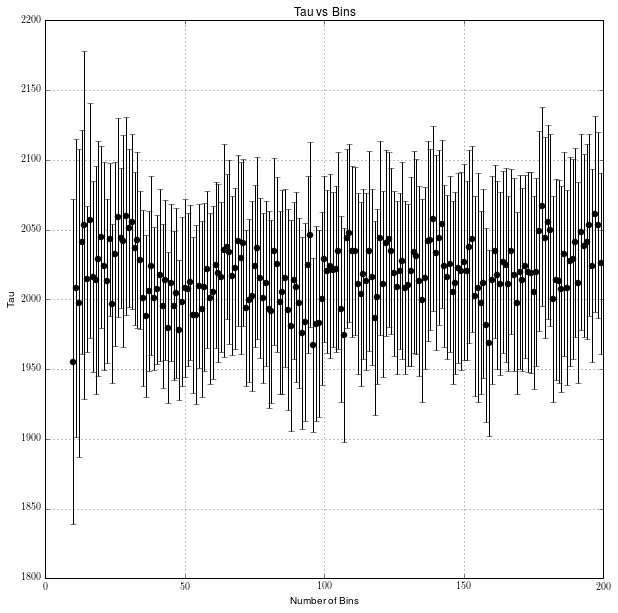

In [116]:
bestValue_Plot(data_208,10,200)

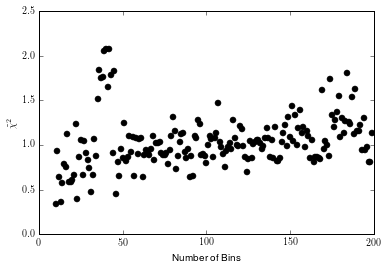

In [117]:
chiSq_Plot(data_400,10,200)

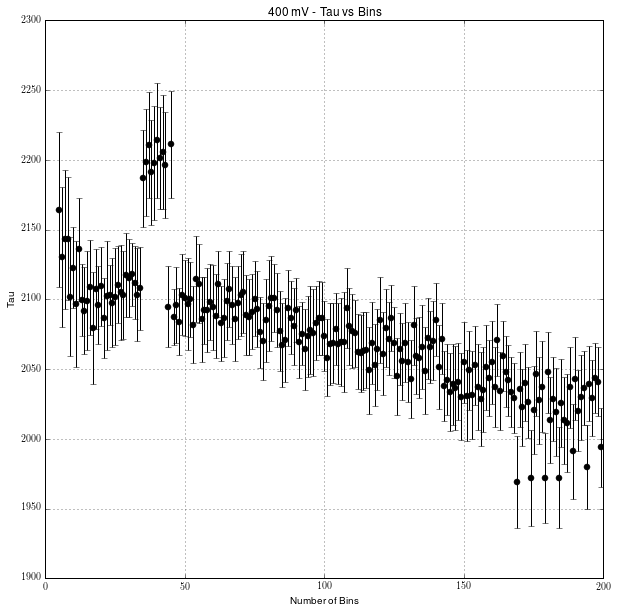

In [126]:
bestValue_Plot(data_400,5,200,'400 mV - Tau vs Bins')

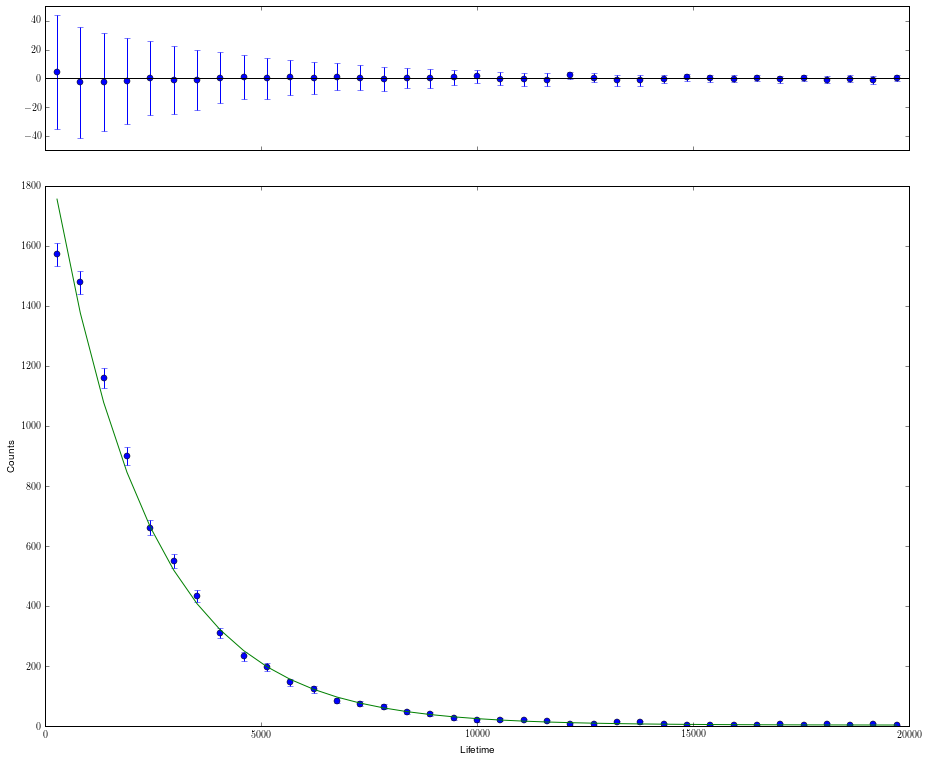

In [122]:
fit_plot(data_400,37)

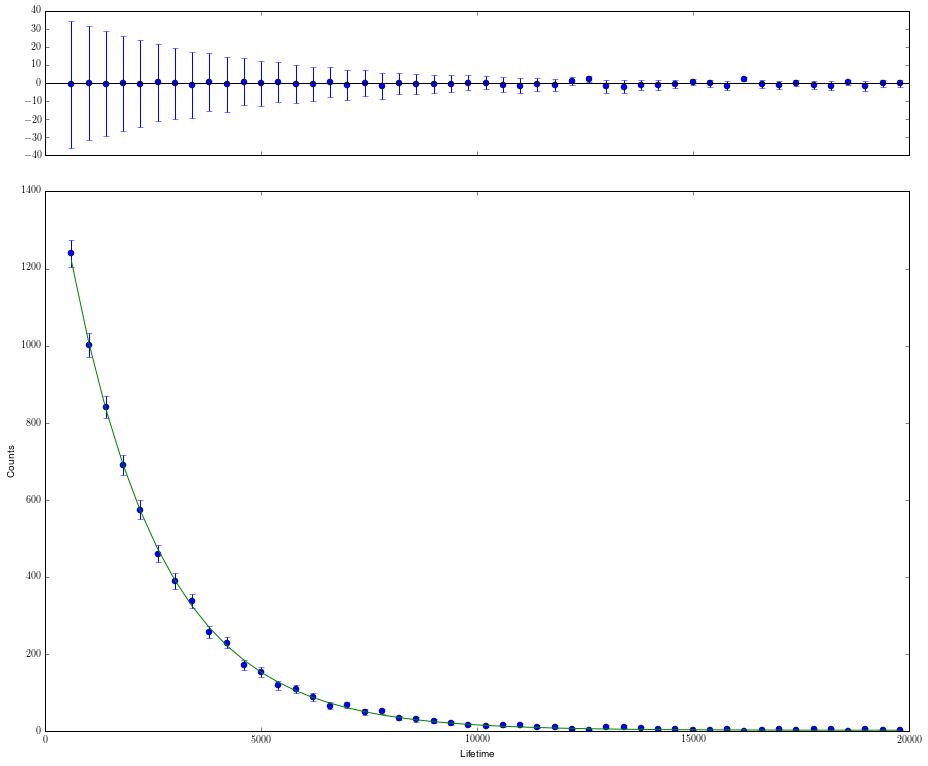

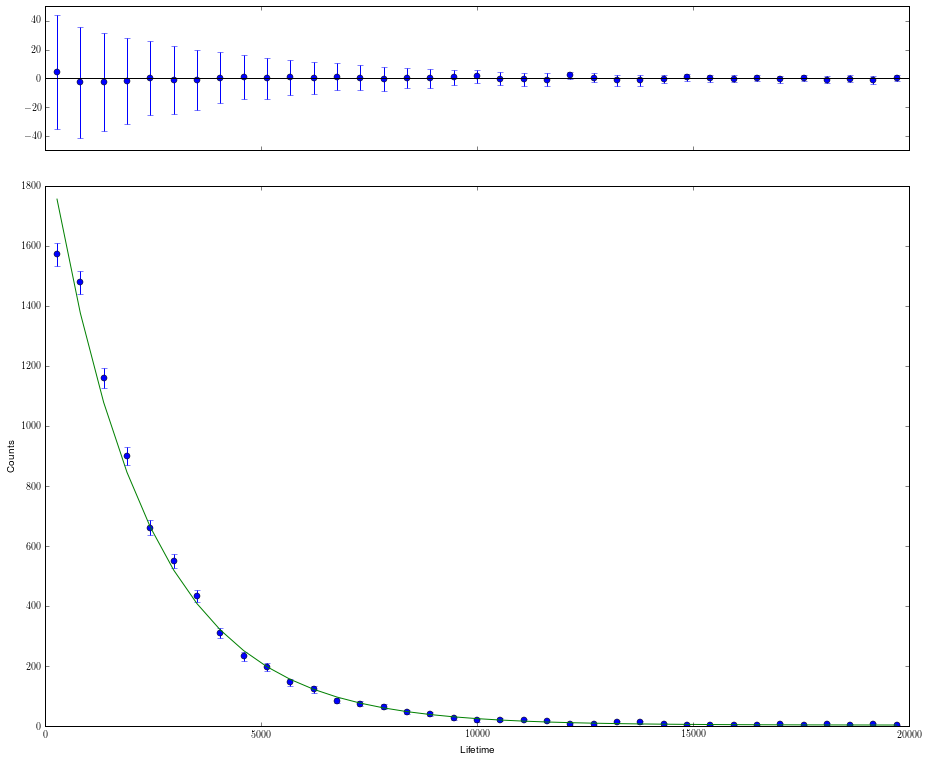

In [129]:
fit_plot(data_400,50)
fit_plot(data_400,37)